These first few blocks are just the simulator code, I could have imported them, but this was simpler

In [1]:
#these are the classes used in the simulation
class PhysicalQubit:
#relatively simple, only holds location and if it has undergone an x or z error

    def __init__(self, row, col):
        self.Xvalue = 0
        self.Zvalue = 0
        self.locationRow = row
        self.locationCol = col

    def flip_value(self, gate_type):
        if gate_type == 'x' or gate_type == 'y':
            if self.Xvalue == 1:
                self.Xvalue = 0
            else:
                self.Xvalue = 1

        if gate_type == 'z' or gate_type == 'y':
            if self.Zvalue == 1:
                self.Zvalue = 0
            else:
                self.Zvalue = 1

    def clear(self):
        self.Xvalue = 0
        self.Zvalue = 0

    def return_Xvalue(self):
        return self.Xvalue

    def return_Zvalue(self):
        return self.Zvalue

In [2]:
class AncillaQubit:

    def __init__(self, type, name):
        self.AType = type
        self.qubits = []
        self.on = False
        self.name = name
        self.row = 0
        self.col = 0

    def add_qubit(self, new_qubit):
        self.qubits.append(new_qubit)

    def setLocation(self, row, col):
        self.row = row
        self.col = col

    def connected(self, phys_qubit):
        if phys_qubit in self.qubits:
            return True
        else:
            return False

    #returns the measurement based on the error observed on its physical qubits
    def measure(self):
        total = 0
        if self.AType == "x":
            if len(self.qubits) == 2:
                if self.qubits[0].return_Xvalue() == self.qubits[1].return_Xvalue():
                    total = 1
                else:
                    total = -1
            if len(self.qubits) == 4:
                if (self.qubits[0].return_Xvalue() + self.qubits[1].return_Xvalue() + self.qubits[2].return_Xvalue() + self.qubits[3].return_Xvalue()) % 2 == 0:
                    total = 1
                else:
                    total = -1

        elif self.AType == "z":
            if len(self.qubits) == 2:
                if self.qubits[0].return_Zvalue() == self.qubits[1].return_Zvalue():
                    total += 1
                else:
                    total -= 1
            if len(self.qubits) == 4:
                if (self.qubits[0].return_Zvalue() + self.qubits[1].return_Zvalue() + self.qubits[2].return_Zvalue() + self.qubits[3].return_Zvalue()) % 2 == 0:
                    total = 1
                else:
                    total = -1
        return total

In [3]:
# Inspired by rotated surface code of different depths, as described here:https://arxiv.org/pdf/1811.12456.pdf
import itertools
from random import *
import numpy as np
from collections import defaultdict, Counter


#representation of the rotated surface code for arbitary depth
#contains all the ancilla and physical qubits
#also includes methods to add error on both the physical qubits and the ancilla
class ToricCircuit:

    def __init__(self, depth):
        self.depth = depth
        # initialize qubits to zero
        self.qubits = {}
        self.ancilla = []
        self.ancilla_matrix = [[1]*depth for _ in range(depth+1)]
        self.error_qubits_x = []
        self.error_qubits_z = []
        self.measurement_errs = {}
        for i in range(depth):
            for j in range(depth):
                qubit = PhysicalQubit(i, j)
                self.qubits.update({str(i) + str(j): qubit})
        self.create_ancilla()

    def add_random_error(self, num):
        # random flips with equal probability of x,z,or y on any qubits
        # could possibly flip already corrupted qubits to fix them
        # choose the number of physical qubits to put errors on
        error_types = ['x', 'y', 'z']
        logical_dict = []
        for i in range(num):
            a = randint(0, self.depth-1)
            b = randint(0, self.depth-1)

            type = choice(error_types)
            self.qubits.get(str(a) + str(b)).flip_value(type)
            if type == "x" or type == "y":
                self.error_qubits_x.append(self.qubits.get(str(a) + str(b)))

            if type == "z" or type == "y":
                self.error_qubits_z.append(self.qubits.get(str(a) + str(b)))

    def get_syndrome(self, prob_err):

        return_dict = {}
        for a in self.ancilla:
            return_dict.update({a.name: a.measure()})

        num_errs = 0
        if prob_err > 0:
            for a in return_dict:
                rand = random()
                if rand <= prob_err:
                    num_errs += 1
                    if return_dict[a] == -1:
                        return_dict[a] = 1
                    else:
                        return_dict[a] = -1

        else:
            errs = Counter()
            for x in self.error_qubits_x:
                errs.update({"X" + str(x.locationRow) + str(x.locationCol)})
            for z in self.error_qubits_z:
                errs.update({"Z" + str(z.locationRow) + str(z.locationCol)})

            errors_to_remove = []
            for e in errs: #for decoding, duplicate errors flip back the qubit to its intended state, so remove pairs
                if errs[e] %2 == 0:
                    errors_to_remove.append(e)
            for x in errors_to_remove:
                del errs[x]
            return_dict.update({"Labels": list(errs)})

        return return_dict


    def add_physical_errs(self, err_list):
        for err in err_list:
            if err[0] == 'x':
                self.qubits.get(str(err[1]) + str(err[2])).flip_value('x')
                self.error_qubits_x.append(self.qubits.get(str(err[1]) + str(err[2])))
            elif err[0] == 'z':
                self.qubits.get(str(err[1]) + str(err[2])).flip_value('z')
                self.error_qubits_z.append(self.qubits.get(str(err[1]) + str(err[2])))
            elif err[0] == 'y':
                self.qubits.get(str(err[1]) + str(err[2])).flip_value('x')
                self.error_qubits_x.append(self.qubits.get(str(err[1]) + str(err[2])))
                self.qubits.get(str(err[1]) + str(err[2])).flip_value('z')
                self.error_qubits_z.append(self.qubits.get(str(err[1]) + str(err[2])))
            else:
                print("invalid input in circuit")
        return

    def clear_errors(self):
        for err_x in self.error_qubits_x:
            self.qubits.get(str(err_x.locationRow) + str(err_x.locationCol)).clear()

        for err_z in self.error_qubits_z:
            self.qubits.get(str(err_z.locationRow) + str(err_z.locationCol)).clear()

        self.error_qubits_z.clear()
        self.error_qubits_x.clear()

    def get_physical_errs(self):
        return_dict = {}
        errs = []
        for x in self.error_qubits_x:
            errs.append("X" + str(x.locationRow) + str(x.locationCol))
        for z in self.error_qubits_z:
            errs.append("Z" + str(z.locationRow) + str(z.locationCol))
        return_dict.update({"Labels": errs})

        return return_dict

    def correct_errs(self, err_list):
        err_list = err_list[0]
        for err in err_list:
            if err[0] == 'X':
                self.qubits.get(str(err[1]) + str(err[2])).flip_value('x')
                if self.qubits.get(str(err[1]) + str(err[2])) in self.error_qubits_x:
                    self.error_qubits_x.remove(self.qubits.get(str(err[1]) + str(err[2])))
                    print("Corrected qubit X"+str(err[1]) + str(err[2]))
                else:
                    self.error_qubits_x.append(self.qubits.get(str(err[1]) + str(err[2])))
                    print("Incorrectly flipped qubit X" + str(err[1]) + str(err[2]))
            elif err[0] == 'Z':
                self.qubits.get(str(err[1]) + str(err[2])).flip_value('z')
                if self.qubits.get(str(err[1]) + str(err[2])) in self.error_qubits_z:
                    self.error_qubits_z.remove(self.qubits.get(str(err[1]) + str(err[2])))
                    print("Corrected qubit Z" + str(err[1]) + str(err[2]))
                else:
                    self.error_qubits_z.append(self.qubits.get(str(err[1]) + str(err[2])))
                    print("Incorrectly flipped qubit Z" + str(err[1]) + str(err[2]))
            else:
                return

    def check_max_errs(self, max_errors):
        if len(self.error_qubits_x) + len(self.error_qubits_z) > max_errors:
            return False
        else:
            return True

    def create_ancilla(self):
        # This adds the ancilla with their correct physical qubits attached
        # only for depth of 3,5,7 code described here:https://arxiv.org/pdf/1811.12456.pdf
        count = 0

        for i in range(self.depth - 1):

            if i % 2 == 0:
                #start with z ancilla
                j = 0
                while j < self.depth:
                    if i == 0 and j != (self.depth - 1):
                        #ancilla located about the grid
                        newX = AncillaQubit("x", "X" + str(count))
                        newX.add_qubit(self.qubits.get(str(i) + str(j)))
                        newX.add_qubit(self.qubits.get(str(i) + str(j + 1)))
                        newX.setLocation(i,j)
                        self.ancilla.append(newX)
                        count += 1
                    if j == (self.depth - 1):
                        #at the right most edge ancilla
                        newZ = AncillaQubit("z", "Z" + str(count))
                        newZ.add_qubit(self.qubits.get(str(i) + str(j)))
                        newZ.add_qubit(self.qubits.get(str(i + 1) + str(j)))
                        newZ.setLocation(i+1, j)
                        self.ancilla.append(newZ)
                        count += 1

                    #those two if statements check to see if the code is at the upper boundary and adds the ancilla at the top
                    else:
                        newZ = AncillaQubit("z", "Z" + str(count))
                        newZ.add_qubit(self.qubits.get(str(i) + str(j))) #upper left corner
                        newZ.add_qubit(self.qubits.get(str(i) + str(j+1))) # upper right corner
                        newZ.add_qubit(self.qubits.get(str(i+1) + str(j)))  #lower left corner
                        newZ.add_qubit(self.qubits.get(str(i+1) + str(j + 1)))  #lower right corner
                        newZ.setLocation(i+1, j)
                        count += 1

                        newX = AncillaQubit("x", "X" + str(count))
                        newX.add_qubit(self.qubits.get(str(i) + str(j+1)))
                        newX.add_qubit(self.qubits.get(str(i) + str(j + 2)))
                        newX.add_qubit(self.qubits.get(str(i + 1) + str(j+1)))
                        newX.add_qubit(self.qubits.get(str(i + 1) + str(j + 2)))
                        newX.setLocation(i+1, j+1)
                        count += 1

                        self.ancilla.append(newZ)
                        self.ancilla.append(newX)
                    j = j+2
            else:
                #start witth x ancilla, new row
                j = 0
                while j < self.depth-1:
                    if j == 0:
                        #add z ancilla to the far left
                        newZ = AncillaQubit("z","Z" + str(count))
                        newZ.add_qubit(self.qubits.get(str(i) + str(j)))
                        newZ.add_qubit(self.qubits.get(str(i + 1) + str(j)))
                        newZ.setLocation(i+1, j)
                        self.ancilla.append(newZ)
                        count += 1

                    newX = AncillaQubit("x", "X" + str(count))
                    newX.add_qubit(self.qubits.get(str(i) + str(j)))
                    newX.add_qubit(self.qubits.get(str(i) + str(j + 1)))
                    newX.add_qubit(self.qubits.get(str(i + 1) + str(j)))
                    newX.add_qubit(self.qubits.get(str(i + 1) + str(j + 1)))
                    newX.setLocation(i+1, j+1)
                    self.ancilla.append(newX)
                    count += 1

                    if i == (self.depth - 2) and j < (self.depth - 1):
                        #checks if this is the last row, if it is, then add the ancilla on the bottom
                        newX =AncillaQubit("x", "X" + str(count))
                        newX.add_qubit(self.qubits.get(str(i + 1) + str(j + 1)))
                        newX.add_qubit(self.qubits.get(str(i + 1) + str(j + 2)))
                        newX.setLocation(i+2, j+2)
                        self.ancilla.append(newX)
                        count += 1

                    newZ = AncillaQubit("z", "Z" + str(count))
                    newZ.add_qubit(self.qubits.get(str(i) + str(j + 1)))
                    newZ.add_qubit(self.qubits.get(str(i) + str(j + 2)))
                    newZ.add_qubit(self.qubits.get(str(i + 1) + str(j + 1)))
                    newZ.add_qubit(self.qubits.get(str(i + 1) + str(j + 2)))
                    newZ.setLocation(i+1, j+2)
                    count += 1

                    self.ancilla.append(newZ)
                    j = j + 2
        return

In [4]:
from sklearn.preprocessing import MultiLabelBinarizer
import keras

def create_list_from_string(err_list):
    newstring = err_list.replace("'", "")
    new_err_list = newstring.strip('][').split(', ')
    return set(new_err_list)

Using TensorFlow backend.


In [10]:
#this is the same for all depths so I'm just going to comment this portion
#make circuit for sim
circuit = ToricCircuit(3)
d3_dist = []

#make the multilabel binarizer
mlb = MultiLabelBinarizer()
mlb.fit([['X00', 'X01', 'X02', 'X10', 'X11', 'X12', 'X20',
 'X21', 'X22','Z00', 'Z01', 'Z02', 'Z10', 'Z11', 'Z12', 
 'Z20', 'Z21', 'Z22']])

#load NN model
model = keras.models.load_model('model_d3.h5')
model.summary()
model = keras.models.load_model('model_d3_01.h5')
model.summary()

#repeat test 1000 times
for i in range (1000):
    count = 0

    while circuit.check_max_errs(3): #while total data qubit errors < depth
        
        circuit.add_random_error(1) #add an error to the circuit
        syn = circuit.get_syndrome(0) #get the syndrome
        del syn['Labels'] #forget about the labels, not needed at this time
        vals = list(syn.values())
        vals = np.array(vals)
        vals = np.expand_dims(vals, axis=0) #these few lines are just to get the data in the right format

        errors = circuit.get_physical_errs() #get the data qubit errors
        errors = errors.get('Labels')
        print(errors)
        multilabelerrs = mlb.transform([errors])

        print(vals)
        
        prediction = model.predict(vals) #use NN model to predict corrections
        prediction[prediction>=.3]=1 #use threshold found in training 
        prediction[prediction<.3]=0
        correction =mlb.inverse_transform(prediction) #Do the inverse transform to get corrections to use in sim
        print(correction)
        circuit.correct_errs(correction) #correct errrors predicted
        count += 1 #increase count of error correction cycles
        
    circuit.clear_errors() #clear errors of 
    d3_dist.append(count) #k
    
print(d3_dist)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 32)                288       
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 18)                594       
Total params: 4,122
Trainable params: 4,122
Non-trainable params: 0
____________________________________________________

[()]
['X11', 'X20', 'X02', 'Z02']
[[ 1  1  1 -1  1  1  1  1]]
[()]
['Z10']
[[ 1 -1  1  1 -1  1  1  1]]
[()]
['X00', 'Z10']
[[-1 -1  1  1 -1  1  1  1]]
[()]
['X00', 'X10', 'Z10', 'Z10']
[[-1  1  1  1  1 -1  1  1]]
[()]
['X22', 'Z22']
[[ 1  1  1  1  1  1 -1 -1]]
[()]
['X22', 'Z22', 'Z21']
[[ 1  1  1  1  1  1 -1  1]]
[()]
['X22', 'Z22', 'Z21', 'Z22']
[[ 1  1  1  1  1  1 -1 -1]]
[()]
['Z02']
[[ 1  1  1 -1  1  1  1  1]]
[()]
['Z02', 'Z10']
[[ 1 -1  1 -1 -1  1  1  1]]
[()]
['Z02', 'Z10', 'Z20']
[[ 1 -1  1 -1  1  1  1  1]]
[()]
['Z02', 'Z10', 'Z20', 'Z20']
[[ 1 -1  1 -1 -1  1  1  1]]
[()]
['X10', 'Z10']
[[ 1 -1  1  1 -1 -1  1  1]]
[()]
['X10', 'X10', 'Z10']
[[ 1 -1  1  1 -1  1  1  1]]
[()]
['X10', 'X10', 'X01', 'Z10', 'Z01']
[[-1  1 -1  1 -1  1  1  1]]
[()]
['X21', 'Z21']
[[ 1  1  1  1  1 -1 -1 -1]]
[('Z01', 'Z11')]
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z11
['X11']
[[ 1  1 -1  1  1 -1  1  1]]
[()]
['X11', 'Z20']
[[ 1  1 -1  1 -1 -1  1  1]]
[()]
['X11', 'X21', 'Z20', 'Z21']
[

[()]
['X02', 'X11', 'Z01']
[[ 1 -1  1  1  1 -1  1  1]]
[()]
['X02', 'X11', 'X02', 'Z01']
[[ 1 -1 -1  1  1 -1  1  1]]
[('X01', 'X12', 'X20', 'Z01', 'Z11', 'Z21')]
Incorrectly flipped qubit X01
Incorrectly flipped qubit X12
Incorrectly flipped qubit X20
Corrected qubit Z01
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z21
['X11', 'Z11']
[[ 1 -1 -1  1  1 -1  1 -1]]
[('X01', 'X12', 'X20', 'Z01', 'Z11')]
Incorrectly flipped qubit X01
Incorrectly flipped qubit X12
Incorrectly flipped qubit X20
Incorrectly flipped qubit Z01
Corrected qubit Z11
['X01', 'Z01']
[[-1 -1 -1  1  1  1  1  1]]
[()]
['X01', 'X22', 'Z01']
[[-1 -1 -1  1  1  1 -1  1]]
[('X01', 'X02', 'X12', 'X20', 'X22', 'Z01', 'Z02', 'Z11', 'Z12', 'Z20', 'Z21')]
Corrected qubit X01
Incorrectly flipped qubit X02
Incorrectly flipped qubit X12
Incorrectly flipped qubit X20
Corrected qubit X22
Corrected qubit Z01
Incorrectly flipped qubit Z02
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z12
Incorrectly flipped qubit Z20

[('X00', 'X01', 'X02', 'X11', 'X12', 'X20', 'X21', 'X22', 'Z01', 'Z02', 'Z11', 'Z12', 'Z20', 'Z21')]
Incorrectly flipped qubit X00
Incorrectly flipped qubit X01
Incorrectly flipped qubit X02
Incorrectly flipped qubit X11
Incorrectly flipped qubit X12
Incorrectly flipped qubit X20
Corrected qubit X21
Incorrectly flipped qubit X22
Incorrectly flipped qubit Z01
Corrected qubit Z02
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z12
Incorrectly flipped qubit Z20
Incorrectly flipped qubit Z21
['X20']
[[ 1  1  1  1  1 -1  1  1]]
[()]
['X20', 'Z22']
[[ 1  1  1  1  1 -1  1 -1]]
[()]
['X20', 'X22', 'Z22']
[[ 1  1  1  1  1 -1 -1 -1]]
[('Z01', 'Z11')]
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z11
['X11', 'Z11']
[[ 1 -1 -1  1  1 -1  1 -1]]
[('X01', 'X12', 'X20', 'Z01', 'Z11')]
Incorrectly flipped qubit X01
Incorrectly flipped qubit X12
Incorrectly flipped qubit X20
Incorrectly flipped qubit Z01
Corrected qubit Z11
['Z11']
[[ 1 -1  1  1  1  1  1 -1]]
[()]
['X22', 'Z11', 'Z22']

['X22', 'Z00', 'Z22', 'Z02']
[[ 1 -1  1 -1  1  1 -1 -1]]
[('X00', 'X01', 'X02', 'X12', 'X20', 'X22', 'Z01', 'Z02', 'Z11', 'Z12', 'Z21')]
Incorrectly flipped qubit X00
Incorrectly flipped qubit X01
Incorrectly flipped qubit X02
Incorrectly flipped qubit X12
Incorrectly flipped qubit X20
Corrected qubit X22
Incorrectly flipped qubit Z01
Corrected qubit Z02
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z12
Incorrectly flipped qubit Z21
['X00', 'Z00']
[[-1 -1  1  1  1  1  1  1]]
[()]
['X00', 'X02', 'Z00']
[[-1 -1 -1  1  1  1  1  1]]
[()]
['X00', 'X02', 'X00', 'Z00', 'Z00']
[[ 1  1 -1  1  1  1  1  1]]
[()]
['Z10']
[[ 1 -1  1  1 -1  1  1  1]]
[()]
['Z10', 'Z01']
[[ 1  1  1  1 -1  1  1  1]]
[()]
['X10', 'Z10', 'Z01']
[[ 1  1  1  1 -1 -1  1  1]]
[()]
['X10', 'X20', 'Z10', 'Z01', 'Z20']
[[1 1 1 1 1 1 1 1]]
[()]
['X10', 'Z10']
[[ 1 -1  1  1 -1 -1  1  1]]
[()]
['X10', 'Z10', 'Z12']
[[ 1 -1  1 -1 -1 -1  1 -1]]
[('X01', 'X12', 'Z01', 'Z21')]
Incorrectly flipped qubit X01
Incorrectly flipp

[()]
['X20', 'X11', 'X11', 'Z22']
[[ 1  1  1  1  1 -1  1 -1]]
[()]
['X02']
[[ 1  1 -1  1  1  1  1  1]]
[()]
['X02', 'X12']
[[1 1 1 1 1 1 1 1]]
[()]
['X02', 'X12', 'X20', 'Z20']
[[ 1  1  1  1 -1 -1  1  1]]
[()]
['X00']
[[-1  1  1  1  1  1  1  1]]
[()]
['X00', 'X02']
[[-1  1 -1  1  1  1  1  1]]
[()]
['X00', 'X02', 'X20', 'Z20']
[[-1  1 -1  1 -1 -1  1  1]]
[()]
['X01']
[[-1  1 -1  1  1  1  1  1]]
[()]
['X01', 'X01', 'Z01']
[[ 1 -1  1  1  1  1  1  1]]
[()]
['X01', 'X01', 'Z01', 'Z21']
[[ 1 -1  1  1  1  1  1 -1]]
[()]
['X20', 'Z20']
[[ 1  1  1  1 -1 -1  1  1]]
[()]
['X20', 'Z20', 'Z21']
[[ 1  1  1  1 -1 -1  1 -1]]
[()]
['X20', 'X01', 'Z20', 'Z21']
[[-1  1 -1  1 -1 -1  1 -1]]
[('X00', 'X01', 'X02', 'X12', 'X20', 'X22', 'Z01', 'Z02', 'Z11', 'Z12', 'Z20', 'Z21')]
Incorrectly flipped qubit X00
Corrected qubit X01
Incorrectly flipped qubit X02
Incorrectly flipped qubit X12
Corrected qubit X20
Incorrectly flipped qubit X22
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z02
Incorrectly fl

[()]
['X10', 'Z02']
[[ 1  1  1 -1  1 -1  1  1]]
[()]
['X10', 'X00', 'Z02', 'Z00']
[[-1 -1  1 -1  1 -1  1  1]]
[('X00', 'X01', 'X02', 'X11', 'X12', 'X20', 'X21', 'X22', 'Z00', 'Z01', 'Z02', 'Z10', 'Z11', 'Z12', 'Z20', 'Z21')]
Corrected qubit X00
Incorrectly flipped qubit X01
Incorrectly flipped qubit X02
Incorrectly flipped qubit X11
Incorrectly flipped qubit X12
Incorrectly flipped qubit X20
Incorrectly flipped qubit X21
Incorrectly flipped qubit X22
Corrected qubit Z00
Incorrectly flipped qubit Z01
Corrected qubit Z02
Incorrectly flipped qubit Z10
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z12
Incorrectly flipped qubit Z20
Incorrectly flipped qubit Z21
['Z02']
[[ 1  1  1 -1  1  1  1  1]]
[()]
['Z02', 'Z12']
[[ 1  1  1  1  1  1  1 -1]]
[()]
['X22', 'Z02', 'Z12']
[[ 1  1  1  1  1  1 -1 -1]]
[()]
['X22', 'X11', 'Z02', 'Z12']
[[ 1  1 -1  1  1 -1 -1 -1]]
[('X01', 'X12', 'X20', 'Z01', 'Z11', 'Z12', 'Z21')]
Incorrectly flipped qubit X01
Incorrectly flipped qubit X12
Incorrectly 

[[-1  1  1  1  1  1  1  1]]
[()]
['X00', 'X00', 'Z00']
[[ 1 -1  1  1  1  1  1  1]]
[()]
['X00', 'X00', 'X12', 'Z00', 'Z12']
[[ 1 -1 -1 -1  1  1  1 -1]]
[('X00', 'X01', 'X02', 'X12', 'X20', 'X21', 'X22', 'Z01', 'Z02', 'Z11', 'Z12', 'Z21')]
Corrected qubit X00
Incorrectly flipped qubit X01
Incorrectly flipped qubit X02
Corrected qubit X12
Incorrectly flipped qubit X20
Incorrectly flipped qubit X21
Incorrectly flipped qubit X22
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z02
Incorrectly flipped qubit Z11
Corrected qubit Z12
Incorrectly flipped qubit Z21
['X20']
[[ 1  1  1  1  1 -1  1  1]]
[()]
['X20', 'X11']
[[ 1  1 -1  1  1  1  1  1]]
[()]
['X20', 'X11', 'Z22']
[[ 1  1 -1  1  1  1  1 -1]]
[()]
['X20', 'X11', 'X12', 'Z22', 'Z12']
[[ 1  1  1 -1  1  1  1  1]]
[()]
['X20', 'Z20']
[[ 1  1  1  1 -1 -1  1  1]]
[()]
['X20', 'Z20', 'Z20']
[[ 1  1  1  1  1 -1  1  1]]
[()]
['X20', 'X10', 'Z20', 'Z20', 'Z10']
[[ 1 -1  1  1 -1  1  1  1]]
[()]
['X12', 'Z12']
[[ 1  1 -1 -1  1  1  1 -1]]
[()

[('X00', 'X01', 'X02', 'X10', 'X11', 'X12', 'X20', 'X21', 'X22', 'Z00', 'Z01', 'Z02', 'Z10', 'Z11', 'Z12', 'Z20', 'Z21', 'Z22')]
Incorrectly flipped qubit X00
Incorrectly flipped qubit X01
Corrected qubit X02
Incorrectly flipped qubit X10
Incorrectly flipped qubit X11
Incorrectly flipped qubit X12
Incorrectly flipped qubit X20
Corrected qubit X21
Incorrectly flipped qubit X22
Incorrectly flipped qubit Z00
Incorrectly flipped qubit Z01
Corrected qubit Z02
Incorrectly flipped qubit Z10
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z12
Incorrectly flipped qubit Z20
Incorrectly flipped qubit Z21
Incorrectly flipped qubit Z22
['X21']
[[ 1  1  1  1  1 -1 -1  1]]
[()]
['X21', 'Z11']
[[ 1 -1  1  1  1 -1 -1 -1]]
[('X01', 'X12', 'X20', 'Z11', 'Z21')]
Incorrectly flipped qubit X01
Incorrectly flipped qubit X12
Incorrectly flipped qubit X20
Corrected qubit Z11
Incorrectly flipped qubit Z21
['X20']
[[ 1  1  1  1  1 -1  1  1]]
[()]
['X20', 'X20']
[[1 1 1 1 1 1 1 1]]
[()]
['X20', 'X20', 'Z2

[('X01', 'X02', 'X11', 'X12', 'X20', 'X21', 'X22', 'Z01', 'Z02', 'Z11', 'Z12', 'Z20', 'Z21')]
Incorrectly flipped qubit X01
Incorrectly flipped qubit X02
Incorrectly flipped qubit X11
Incorrectly flipped qubit X12
Corrected qubit X20
Incorrectly flipped qubit X21
Incorrectly flipped qubit X22
Incorrectly flipped qubit Z01
Corrected qubit Z02
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z12
Incorrectly flipped qubit Z20
Incorrectly flipped qubit Z21
['Z11']
[[ 1 -1  1  1  1  1  1 -1]]
[()]
['X11', 'Z11']
[[ 1 -1 -1  1  1 -1  1 -1]]
[('X01', 'X12', 'X20', 'Z01', 'Z11')]
Incorrectly flipped qubit X01
Incorrectly flipped qubit X12
Incorrectly flipped qubit X20
Incorrectly flipped qubit Z01
Corrected qubit Z11
['Z20']
[[ 1  1  1  1 -1  1  1  1]]
[()]
['X22', 'Z20', 'Z22']
[[ 1  1  1  1 -1  1 -1 -1]]
[()]
['X22', 'Z20', 'Z22', 'Z22']
[[ 1  1  1  1 -1  1 -1  1]]
[()]
['X02']
[[ 1  1 -1  1  1  1  1  1]]
[()]
['X02', 'X01', 'Z01']
[[-1 -1  1  1  1  1  1  1]]
[()]
['X02', 'X01', 'Z01'

[()]
['X22', 'Z21', 'Z10']
[[ 1 -1  1  1 -1  1 -1 -1]]
[('Z01', 'Z11')]
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z11
['Z20']
[[ 1  1  1  1 -1  1  1  1]]
[()]
['Z20', 'Z22']
[[ 1  1  1  1 -1  1  1 -1]]
[()]
['Z20', 'Z22', 'Z21']
[[ 1  1  1  1 -1  1  1  1]]
[()]
['X21', 'Z20', 'Z22', 'Z21']
[[ 1  1  1  1 -1 -1 -1  1]]
[()]
['Z22']
[[ 1  1  1  1  1  1  1 -1]]
[()]
['X02', 'Z22']
[[ 1  1 -1  1  1  1  1 -1]]
[()]
['X02', 'X00', 'Z22']
[[-1  1 -1  1  1  1  1 -1]]
[()]
['X02', 'X00', 'Z22', 'Z00']
[[-1 -1 -1  1  1  1  1 -1]]
[('X01', 'X12', 'X20', 'Z01', 'Z11', 'Z12', 'Z21')]
Incorrectly flipped qubit X01
Incorrectly flipped qubit X12
Incorrectly flipped qubit X20
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z12
Incorrectly flipped qubit Z21
['Z02']
[[ 1  1  1 -1  1  1  1  1]]
[()]
['X12', 'Z02', 'Z12']
[[ 1  1 -1  1  1  1  1 -1]]
[()]
['X12', 'Z02', 'Z12', 'Z21']
[[ 1  1 -1  1  1  1  1  1]]
[()]
['X12', 'Z12']
[[ 1  1 -1 -1  1  1  1 -1]

[()]
['X22', 'X11', 'Z22', 'Z12']
[[ 1  1 -1 -1  1 -1 -1  1]]
[('X00', 'X01', 'X02', 'X10', 'X11', 'X12', 'X20', 'X21', 'X22', 'Z00', 'Z01', 'Z02', 'Z10', 'Z11', 'Z12', 'Z20', 'Z21', 'Z22')]
Incorrectly flipped qubit X00
Incorrectly flipped qubit X01
Incorrectly flipped qubit X02
Incorrectly flipped qubit X10
Corrected qubit X11
Incorrectly flipped qubit X12
Incorrectly flipped qubit X20
Incorrectly flipped qubit X21
Corrected qubit X22
Incorrectly flipped qubit Z00
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z02
Incorrectly flipped qubit Z10
Incorrectly flipped qubit Z11
Corrected qubit Z12
Incorrectly flipped qubit Z20
Incorrectly flipped qubit Z21
Corrected qubit Z22
['Z10']
[[ 1 -1  1  1 -1  1  1  1]]
[()]
['X12', 'Z10', 'Z12']
[[ 1 -1 -1 -1 -1  1  1 -1]]
[('X01', 'X12', 'X22', 'Z01', 'Z02', 'Z11', 'Z12', 'Z20')]
Incorrectly flipped qubit X01
Corrected qubit X12
Incorrectly flipped qubit X22
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z02
Incorrectly flipped

[('Z01', 'Z11')]
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z11
['X00', 'Z00']
[[-1 -1  1  1  1  1  1  1]]
[()]
['X00', 'X20', 'Z00', 'Z20']
[[-1 -1  1  1 -1 -1  1  1]]
[('X01', 'X12', 'X20', 'X22', 'Z01', 'Z11', 'Z12')]
Incorrectly flipped qubit X01
Incorrectly flipped qubit X12
Corrected qubit X20
Incorrectly flipped qubit X22
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z12
['Z22']
[[ 1  1  1  1  1  1  1 -1]]
[()]
['X22', 'Z22']
[[ 1  1  1  1  1  1 -1 -1]]
[()]
['X22', 'Z22', 'Z00']
[[ 1 -1  1  1  1  1 -1 -1]]
[()]
['X22', 'X22', 'Z22', 'Z00', 'Z22']
[[ 1 -1  1  1  1  1  1  1]]
[()]
['X22', 'Z22']
[[ 1  1  1  1  1  1 -1 -1]]
[()]
['X22', 'X00', 'Z22', 'Z00']
[[-1 -1  1  1  1  1 -1 -1]]
[('X01', 'X12', 'X20', 'Z01', 'Z11', 'Z12')]
Incorrectly flipped qubit X01
Incorrectly flipped qubit X12
Incorrectly flipped qubit X20
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z12
['Z22']
[[ 1  1  1  1  

['X00', 'X22', 'Z02', 'Z22']
[[-1  1  1 -1  1  1 -1 -1]]
[('X00', 'X01', 'X02', 'X12', 'X20', 'X21', 'X22', 'Z01', 'Z02', 'Z11', 'Z12', 'Z20', 'Z21')]
Corrected qubit X00
Incorrectly flipped qubit X01
Incorrectly flipped qubit X02
Incorrectly flipped qubit X12
Incorrectly flipped qubit X20
Incorrectly flipped qubit X21
Corrected qubit X22
Incorrectly flipped qubit Z01
Corrected qubit Z02
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z12
Incorrectly flipped qubit Z20
Incorrectly flipped qubit Z21
['X02']
[[ 1  1 -1  1  1  1  1  1]]
[()]
['X02', 'Z22']
[[ 1  1 -1  1  1  1  1 -1]]
[()]
['X02', 'Z22', 'Z01']
[[ 1 -1 -1  1  1  1  1 -1]]
[()]
['X02', 'X11', 'Z22', 'Z01']
[[ 1 -1  1  1  1 -1  1 -1]]
[('X12', 'X20')]
Incorrectly flipped qubit X12
Incorrectly flipped qubit X20
['X01']
[[-1  1 -1  1  1  1  1  1]]
[()]
['X01', 'X00']
[[ 1  1 -1  1  1  1  1  1]]
[()]
['X01', 'X00', 'X21', 'Z21']
[[ 1  1 -1  1  1 -1 -1 -1]]
[('X01', 'X12', 'X20', 'Z01', 'Z11', 'Z12', 'Z21')]
Corrected qub

[()]
['X02', 'X12', 'X01']
[[-1  1 -1  1  1  1  1  1]]
[()]
['X02', 'X12', 'X01', 'X11', 'Z11']
[[-1 -1  1  1  1 -1  1 -1]]
[('X00', 'X01', 'X02', 'X12', 'X20', 'X21', 'X22', 'Z01', 'Z02', 'Z11', 'Z12', 'Z21')]
Incorrectly flipped qubit X00
Corrected qubit X01
Corrected qubit X02
Corrected qubit X12
Incorrectly flipped qubit X20
Incorrectly flipped qubit X21
Incorrectly flipped qubit X22
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z02
Corrected qubit Z11
Incorrectly flipped qubit Z12
Incorrectly flipped qubit Z21
['X00']
[[-1  1  1  1  1  1  1  1]]
[()]
['X00', 'X20', 'Z20']
[[-1  1  1  1 -1 -1  1  1]]
[()]
['X00', 'X20', 'X21', 'Z20']
[[-1  1  1  1 -1  1 -1  1]]
[()]
['X02', 'Z02']
[[ 1  1 -1 -1  1  1  1  1]]
[()]
['X02', 'Z02', 'Z20']
[[ 1  1 -1 -1 -1  1  1  1]]
[()]
['X02', 'Z02', 'Z20', 'Z20']
[[ 1  1 -1 -1  1  1  1  1]]
[()]
['X10', 'Z10']
[[ 1 -1  1  1 -1 -1  1  1]]
[()]
['X10', 'Z10', 'Z01']
[[ 1  1  1  1 -1 -1  1  1]]
[()]
['X10', 'X10', 'Z10', 'Z01', 'Z10']
[[ 1 -1

[()]
['X10', 'X22', 'Z10']
[[ 1 -1  1  1 -1 -1 -1  1]]
[('X01', 'X02', 'X11', 'X12', 'X20', 'X22', 'Z01', 'Z02', 'Z11', 'Z12', 'Z20', 'Z21')]
Incorrectly flipped qubit X01
Incorrectly flipped qubit X02
Incorrectly flipped qubit X11
Incorrectly flipped qubit X12
Incorrectly flipped qubit X20
Corrected qubit X22
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z02
Incorrectly flipped qubit Z11
Incorrectly flipped qubit Z12
Incorrectly flipped qubit Z20
Incorrectly flipped qubit Z21
['X11', 'Z11']
[[ 1 -1 -1  1  1 -1  1 -1]]
[('X01', 'X12', 'X20', 'Z01', 'Z11')]
Incorrectly flipped qubit X01
Incorrectly flipped qubit X12
Incorrectly flipped qubit X20
Incorrectly flipped qubit Z01
Corrected qubit Z11
['X11']
[[ 1  1 -1  1  1 -1  1  1]]
[()]
['X11', 'X22']
[[ 1  1 -1  1  1 -1 -1  1]]
[('X01', 'X12', 'Z01', 'Z11')]
Incorrectly flipped qubit X01
Incorrectly flipped qubit X12
Incorrectly flipped qubit Z01
Incorrectly flipped qubit Z11
['X21', 'Z21']
[[ 1  1  1  1  1 -1 -1 -1]]
[('Z01', 

In [ ]:
circuit = ToricCircuit(5)
d5_dist = []
mlb = MultiLabelBinarizer()
mlb.fit([['', 'X00', 'X01', 'X02', 'X03', 'X04', 'X10', 'X11', 'X12', 'X13', 'X14', 'X20',
 'X21', 'X22', 'X23', 'X24', 'X30', 'X31', 'X32', 'X33', 'X34', 'X40', 'X41', 'X42',
 'X43', 'X44', 'Z00', 'Z01', 'Z02', 'Z03', 'Z04', 'Z10', 'Z11', 'Z12', 'Z13', 'Z14',
 'Z20', 'Z21', 'Z22', 'Z23', 'Z24', 'Z30', 'Z31', 'Z32', 'Z33', 'Z34', 'Z40', 'Z41',
 'Z42', 'Z43', 'Z44']])
model = keras.models.load_model('model_d5.h5')
for i in range(1000):
    count = 0
    while circuit.check_max_errs(5):
        circuit.add_random_error(1)
        syn = circuit.get_syndrome(0)
        del syn['Labels']
        vals = list(syn.values())
        vals = np.array(vals)
        #vals = np.where(vals == -1, 0, vals)
        vals = np.expand_dims(vals, axis=0)

        errors = circuit.get_physical_errs()
        errors = errors.get('Labels')
        print(errors)
        multilabelerrs = mlb.transform([errors])
        #print(multilabelerrs[0])

        prediction = model.predict(vals)
        prediction[prediction>=.5]=1
        prediction[prediction<.5]=0
        correction =mlb.inverse_transform(prediction)
        print(correction)
        circuit.correct_errs(correction)
        count += 1
    circuit.clear_errors()
    d5_dist.append(count)
    
print(d5_dist)

In [ ]:
circuit = ToricCircuit(7)
d7_dist = []
mlb = MultiLabelBinarizer()
mlb.fit([['','X00', 'X01', 'X02', 'X03', 'X04','X05', 'X06', 'X10', 'X11', 'X12', 'X13',
 'X14', 'X15', 'X16', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X30', 'X31',
 'X32', 'X33', 'X34', 'X35', 'X36', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46',
 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X60', 'X61', 'X62', 'X63', 'X64',
 'X65', 'X66', 'Z00', 'Z01', 'Z02', 'Z03', 'Z04', 'Z05', 'Z06', 'Z10', 'Z11', 'Z12',
 'Z13', 'Z14', 'Z15', 'Z16', 'Z20', 'Z21', 'Z22', 'Z23', 'Z24', 'Z25', 'Z26', 'Z30',
 'Z31', 'Z32', 'Z33', 'Z34', 'Z35', 'Z36', 'Z40', 'Z41', 'Z42', 'Z43', 'Z44', 'Z45',
 'Z46', 'Z50', 'Z51', 'Z52', 'Z53', 'Z54', 'Z55', 'Z56', 'Z60', 'Z61', 'Z62', 'Z63',
 'Z64', 'Z65', 'Z66']])
model = keras.models.load_model('model_d7.h5')

for i in range(1000):
    count = 0
    while circuit.check_max_errs(7):
        circuit.add_random_error(1)
        syn = circuit.get_syndrome(0)
        del syn['Labels']
        vals = list(syn.values())
        vals = np.array(vals)
        #vals = np.where(vals == -1, 0, vals)
        vals = np.expand_dims(vals, axis=0)

        errors = circuit.get_physical_errs()
        errors = errors.get('Labels')
        print(errors)
        multilabelerrs = mlb.transform([errors])
        #print(multilabelerrs[0])

        prediction = model.predict(vals)
        prediction[prediction>=.4]=1
        prediction[prediction<.4]=0
        correction =mlb.inverse_transform(prediction)
        print(correction)
        circuit.correct_errs(correction)
        count += 1

    circuit.clear_errors()
    d7_dist.append(count)
    
print(d7_dist)

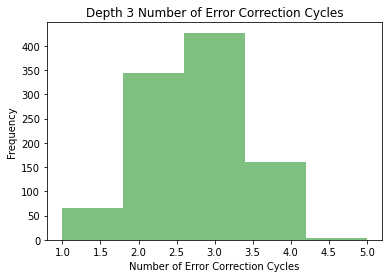

Mean: 2.696
Standard Deviation: 0.829206849947587


In [11]:
#look at the distributions for all 
import matplotlib.pyplot as plt
import statistics
#do this for depth 3:
num_bins_3 = 5
plt.hist(d3_dist, num_bins_3, color='g', alpha=.5)
plt.gca().set(title='Depth 3 Number of Error Correction Cycles', xlabel = "Number of Error Correction Cycles", ylabel='Frequency')
plt.show()
mean_d3 = sum(d3_dist) / len(d3_dist)
sd_d3 = statistics.pstdev(d3_dist) 
print('Mean: ' + str(mean_d3))
print('Standard Deviation: ' + str(sd_d3))

In [ ]:
num_bins_5 = 10
plt.hist(d5_dist, num_bins_5, facecolor='blue', alpha=.5)
plt.gca().set(title='Depth 5 Number of Error Correction Cycles', xlabel = "Number of Error Correction Cycles", ylabel='Frequency')
plt.show()
mean_d5 = sum(d5_dist) / len(d5_dist)
mean_d5 = sum(d5_dist) / len(d5_dist)
sd_d5 = statistics.pstdev(d5_dist) 
print('Mean: ' + str(mean_d5))
print('Standard Deviation: ' + str(sd_d5))

In [ ]:
num_bins_7 = 10
plt.hist(d7_dist, num_bins_7, facecolor='r', alpha=.5)
plt.gca().set(title='Depth 7 Number of Error Correction Cycles', xlabel = "Number of Error Correction Cycles", ylabel='Frequency')
plt.show()
mean_d7 = sum(d7_dist) / len(d7_dist)
mean_d3 = sum(d3_dist) / len(d3_dist)
sd_d7 = statistics.pstdev(d7_dist) 
print('Mean: ' + str(mean_d7))
print('Standard Deviation: ' + str(sd_d7))